In [19]:
from datetime import date, timedelta
from binance.binance_k_line_repository import load_k_lines

interval_days = 1
interval_minutes = interval_days * 24 * 60
interval_date_from: date = date.today() - timedelta(days=3 + interval_days - 1)
interval_date_to: date = date.today() - timedelta(days=3)

symbol: str = "ETHUSDT"

raw_k_lines = load_k_lines(symbol, interval_date_from, interval_date_to)

display(raw_k_lines)

,open_timestamp_millis,open_price,high_price,low_price,close_price,volume,close_timestamp_millis,quote_asset_volume,trades_count,taker_buy_base_asset_volume,taker_buy_quote_asset_volume,ignore
0,1685404800000,1891.51,1892.39,1890.58,1892.38,2500.909,1685404859999,4.730417e+06,2092,887.821,1.679534e+06,0
1,1685404860000,1892.39,1892.48,1891.27,1891.50,1235.913,1685404919999,2.338174e+06,1433,540.963,1.023308e+06,0
2,1685404920000,1891.49,1892.21,1891.49,1892.03,327.455,1685404979999,6.194985e+05,660,201.250,3.807319e+05,0
3,1685404980000,1892.03,1892.39,1892.02,1892.39,282.316,1685405039999,5.342203e+05,480,228.945,4.332281e+05,0
4,1685405040000,1892.39,1892.40,1892.38,1892.40,227.935,1685405099999,4.313420e+05,348,197.710,3.741448e+05,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1435,1685490900000,1899.13,1899.14,1899.12,1899.13,214.351,1685490959999,4.070806e+05,247,131.321,2.493960e+05,0
1436,1685490960000,1899.14,1899.78,1899.13,1899.78,343.494,1685491019999,6.524533e+05,417,285.382,5.420660e+05,0
1437,1685491020000,1899.79,1899.92,1899.78,1899.91,396.083,1685491079999,7.525021e+05,302,289.270,5.495670e+05,0
1438,1685491080000,1899.91,1899.99,1899.91,1899.99,125.965,1685491139999,2.393272e+05,270,102.159,1.940971e+05,0


In [20]:
import pandas as pd

k_lines = raw_k_lines[["close_price"]]
k_lines.index = pd.to_datetime(raw_k_lines["open_timestamp_millis"], unit="ms")
k_lines.index.name = "open_datetime"

k_lines

,close_price
open_datetime,
2023-05-30 00:00:00,1892.38
2023-05-30 00:01:00,1891.50
2023-05-30 00:02:00,1892.03
2023-05-30 00:03:00,1892.39
2023-05-30 00:04:00,1892.40
...,...
2023-05-30 23:55:00,1899.13
2023-05-30 23:56:00,1899.78
2023-05-30 23:57:00,1899.91


In [21]:
from numpy import float16, float64


assert len(k_lines) == interval_minutes

assert len(k_lines[k_lines.isna().any(axis=1)]) == 0
assert len(k_lines[k_lines.isnull().any(axis=1)]) == 0

assert k_lines.dtypes["close_price"] == float64
assert len(k_lines[k_lines["close_price"] < 0]) == 0

# TODO check ordering and increment == 1

<Axes: xlabel='open_datetime'>

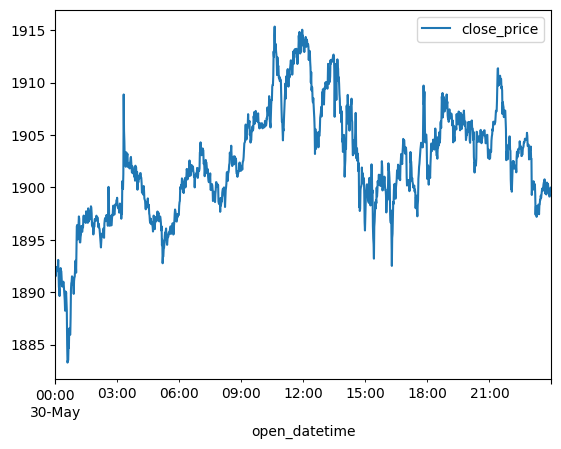

In [22]:
k_lines.plot.line(use_index=True)

In [23]:
k_lines_features = k_lines.copy()

k_lines_features["is_next_close_price_greater"] = (
    k_lines_features["close_price"]
    .shift(-1)
    .rolling(2)
    .apply(lambda x: x.iloc[1] > x.iloc[0])
)

k_lines_features = k_lines_features[~k_lines_features.isna().any(axis=1)]

display(k_lines_features)

,close_price,is_next_close_price_greater
open_datetime,,
2023-05-30 00:01:00,1891.50,1.0
2023-05-30 00:02:00,1892.03,1.0
2023-05-30 00:03:00,1892.39,1.0
2023-05-30 00:04:00,1892.40,0.0
2023-05-30 00:05:00,1891.99,1.0
...,...,...
2023-05-30 23:54:00,1899.13,0.0
2023-05-30 23:55:00,1899.13,1.0
2023-05-30 23:56:00,1899.78,1.0


In [24]:
ml_test_dataset_size = 300

train_k_lines_features = k_lines_features.iloc[:-ml_test_dataset_size]
test_k_lines_features = k_lines_features.iloc[-ml_test_dataset_size:]

In [25]:
from sklearn.ensemble import RandomForestClassifier

model_input_columns = ["close_price"]
model_target_column = "is_next_close_price_greater"

model = RandomForestClassifier(n_estimators=100, min_samples_split=200, random_state=1)
model.fit(
    train_k_lines_features[model_input_columns],
    train_k_lines_features[model_target_column],
)

RandomForestClassifier(min_samples_split=200, random_state=1)